# Hotel booking cancellation prediction
Authors:
* DAU Hai Dang
* Le Ha Quang
* TRAN Duc Dung

In [1]:
#Install if necessary
#!pip install https://api.github.com/repos/paris-saclay-cds/ramp-workflow/zipball/master

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [3]:
import numpy as np
import problem
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style="whitegrid")

## Table of content
1. [Introduction](#ph1)
2. [Exploratory Data Analysis](#ph2)
3. [Workflow](#ph3)
4. [Submission](#ph4)

## Introduction <a name="ph1"></a>

In the hospitality industry, which includes lodging, event planning, transportation, travelling or cuisine line, booking helps to provide the right product to right customer at the right time. Despite its benefits, booking cancellation option puts the services at risk. In the case of hotels, vacant capacity may happen when a guest cancel a booking or doesn't show up. While cancellations can occur due to reasonable causes like bad weather, working schedule changes, illness, etc, nowadays a great number of them happens because people search for best deals. Although, hotels can use overbooking or cancellation policy, overbooking gives a bad expericence by not allowing a customer to check in, while cancellation policy can reduce the number of bookings and reduce the income.

To overcome this problem, we propose using machine learning to predict the probility of cancellation for each reservation. This prediction helps the management decision, improve the experience of customers and the hotel's revenue. The model can be retrained regularly as the data accumulates.

<img src="./img/hotel.jpg",width=500,height=500>

Despite important business implications, real-world data about hotel booking cancellation are not abundant. Recently, researchers from Portugal published a set of booking data from two real hotels in the _Data in Bref_ journal. The original article, downloaded from Elsevier's _ScienceDirect_, is available in the _data/raw_ folder.

The data we use here comes from the "H1" dataset described in the article. It concerns a resort hotel in the region of Algarve. Detailed explanations about the meaning of the variables are given in the article. We took this dataset H1, do some slight preprocessing, and splitted it into two files _data/train.csv_ and _data/test.csv_. All these preprocessing steps are found in the data/raw/process_raw.py file.

To be simple, each row is a hotel booking reservation with columns describing features of that reservation (when was the reservation made? How many days the customer wanted to stay? How many adults and how many children? etc...). The target column is the IsCanceled column, indicating whether or not the booking is finally canceled. There are approximately 40000 rows. The train data contains about 30000 rows and the rest is in the test data.

### KPI and Metric

If the hotel predicts that a customer's reservation is likely to be canceled, the reception has the following solutions:
* It can either ask for more guarantee from the concerned customer, for example, by asking for a higher deposit fee.
* It can also allow other customers to be on the waitlist for the room/time slot that the likely-to-cancel customer reserved.

If a the customer's reservation was predicted to be canceled, but finally it turns out that the customer does not cancel the reservation (false positive), there is a potential cost A for the hotel. If the hotel demanded stricter guarantees from the customer, the customer might feel that the hotel did not trust him, especially if he is a returning customer. If the hotel allowed other customers to be on the waitlist, finally it cannot accomodate their reservations, therefore creates a frustration on these customers.

If the prediction was that the customer's reservation is not canceled but in fact it is canceled (false negative), there is a clear cost B for the hotel, because the hotel might fail to take preventive actions and might end up having an empty room.

From a business point of view, it is reasonable to assume that the cost B is higher than the cost A (if we look at the analyses above, we see that A is rather a vague psychological cost which is not even sure to be realized).

In classification terms, the recall score is more important than the precision score. To reflect this, we use a Modified F1 metric (abbreviated __mf1__ below), where, for simplicity, the precision's weight is 1 and the recall's weight is 3. The exact weight should be determined by a more thorough business analytics.

### Analysis of our particular hotel

In the case of our particular hotel, the exploratory data analysis reveals interesting patterns that can justify the use of machine learning to predict cancellations from a business point of view. Please look at the Exploratory Data Analysis section.

## Exploratory data analysis <a name="ph2"></a>

Let us load the data and have a quick look at its features.

In [4]:
data = pd.read_csv('data/train.csv')
data.head()

,IsCanceled,LeadTime,ArrivalDateMonth,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,Babies,...,AssignedRoomType,BookingChanges,DepositType,Agent,Company,DaysInWaitingList,CustomerType,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests
0,0,187,July,28,9,2,5,2,0,0,...,A,0,No Deposit,240,NULL,0,Transient,83.00,0,2
1,1,0,September,37,9,0,1,1,0,0,...,F,0,No Deposit,NULL,NULL,0,Transient,146.00,0,2
2,1,156,September,36,2,2,5,2,0,0,...,E,0,No Deposit,171,NULL,0,Transient,98.00,0,0
3,0,5,December,51,19,0,1,2,0,0,...,D,0,No Deposit,NULL,NULL,0,Transient-Party,43.00,0,1
4,0,3,October,41,8,0,3,2,0,0,...,D,0,No Deposit,250,NULL,0,Transient,73.67,0,0


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32048 entries, 0 to 32047
Data columns (total 28 columns):
IsCanceled                     32048 non-null int64
LeadTime                       32048 non-null int64
ArrivalDateMonth               32048 non-null object
ArrivalDateWeekNumber          32048 non-null int64
ArrivalDateDayOfMonth          32048 non-null int64
StaysInWeekendNights           32048 non-null int64
StaysInWeekNights              32048 non-null int64
Adults                         32048 non-null int64
Children                       32048 non-null int64
Babies                         32048 non-null int64
Meal                           32048 non-null object
Country                        31677 non-null object
MarketSegment                  32048 non-null object
DistributionChannel            32048 non-null object
IsRepeatedGuest                32048 non-null int64
PreviousCancellations          32048 non-null int64
PreviousBookingsNotCanceled    32048 non-null int64
Re

We see that there is no missing data, except in the Country column. We can therefore fill all missing data with -1.

In [6]:
data = data.fillna(-1)

Let us now see how many categories each non-binary categorical variable has.

In [7]:
cat_cols = [col for col in data.columns if str(data[col].dtype) == 'object']
no_cats = [len(set(data[col])) for col in cat_cols]
pd.DataFrame({'Column': cat_cols, 'Number of categories': no_cats})

,Column,Number of categories
0,ArrivalDateMonth,12
1,Meal,5
2,Country,118
3,MarketSegment,6
4,DistributionChannel,4
5,ReservedRoomType,10
6,AssignedRoomType,11
7,DepositType,3
8,Agent,178
9,Company,226


For numerical or binary variables, the **describe** function provides valuable insights.

In [8]:
data.describe()

,IsCanceled,LeadTime,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,Babies,IsRepeatedGuest,PreviousCancellations,PreviousBookingsNotCanceled,BookingChanges,DaysInWaitingList,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests
count,32048.000000,32048.000000,32048.000000,32048.000000,32048.000000,32048.000000,32048.000000,32048.000000,32048.000000,32048.000000,32048.000000,32048.000000,32048.000000,32048.000000,32048.000000,32048.000000,32048.000000
mean,0.276804,92.450012,27.088492,15.802733,1.186252,3.124282,1.866232,0.128838,0.013885,0.044496,0.099663,0.150743,0.289066,0.525119,95.043906,0.138698,0.618198
std,0.447426,97.066314,13.978094,8.892396,1.143512,2.444580,0.683958,0.444471,0.118869,0.206197,1.325955,1.027454,0.727221,7.388141,61.556252,0.352785,0.813272
min,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-6.380000,0.000000,0.000000
25%,0.000000,10.000000,15.000000,8.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,50.000000,0.000000,0.000000
50%,0.000000,57.000000,28.000000,16.000000,1.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,75.000000,0.000000,0.000000
75%,1.000000,154.000000,38.000000,24.000000,2.000000,5.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,125.000000,0.000000,1.000000
max,1.000000,737.000000,53.000000,31.000000,19.000000,50.000000,55.000000,10.000000,2.000000,1.000000,26.000000,28.000000,17.000000,185.000000,450.000000,8.000000,5.000000


Some first observations:
* The problem is imbalanced (because mean of IsCanceled is 0.28). This is confirmed by the plot below
* This hotel is very busy. Mean of LeadTime is 92.5, which means that most bookings take place in average 90 days before arrival time. This makes cancellation prediction problem very important from a business point of view.
* Mean of IsRepeatedGuest is 0.04, so most guests are in fact new ones. This means that "manual" cancellation prediction might be difficult, and machine learning techniques can prove to be useful.

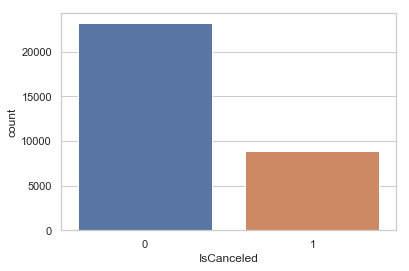

In [9]:
sns.countplot(x = 'IsCanceled', data = data)

Let us now look at the relation of each variable with the target column. We first consider categorical variables (with a small number of categories, so that they can be visualized) or "categorical-like" variables (variables which take less than 12 different values). For each category, we plot the empirical cancellation probability as well as the associated confidence interval. The confidence interval is important because the number of data for each category may be different. While 300 cancellations over 600 bookings and 3 cancellations over 6 bookings give both an empirical cancellation probability of 0.5, in fact in the later example we do not have enough data to conclude.

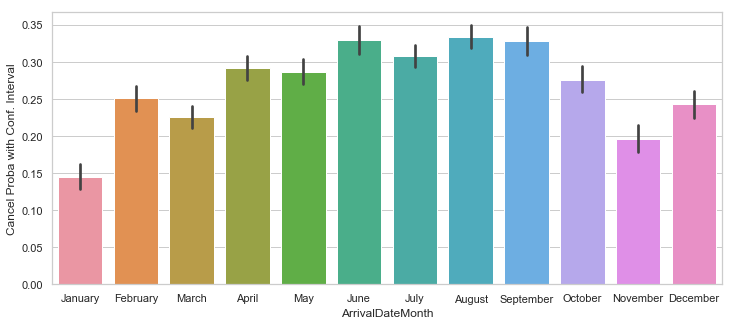

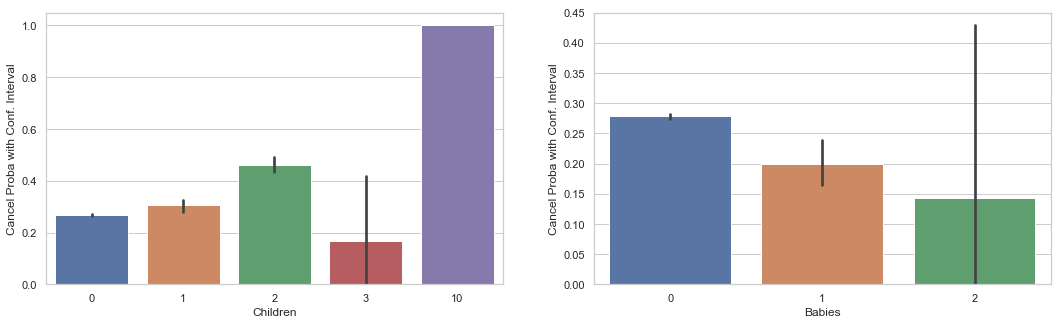

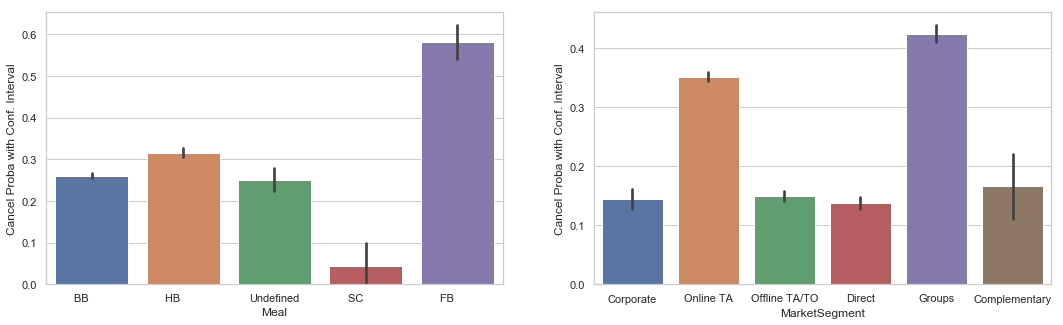

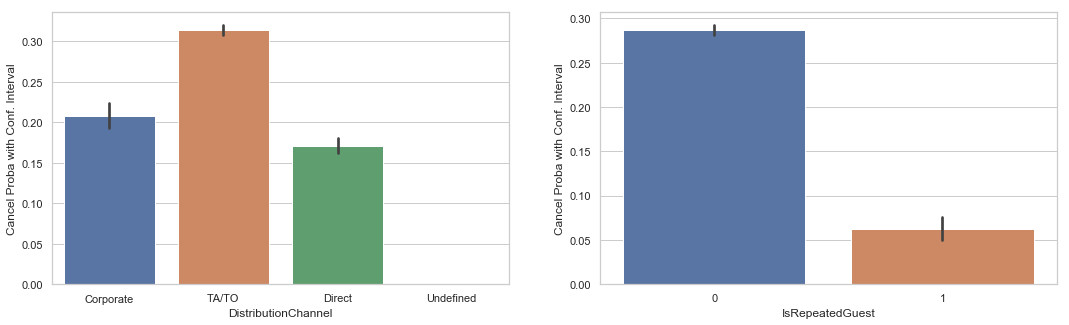

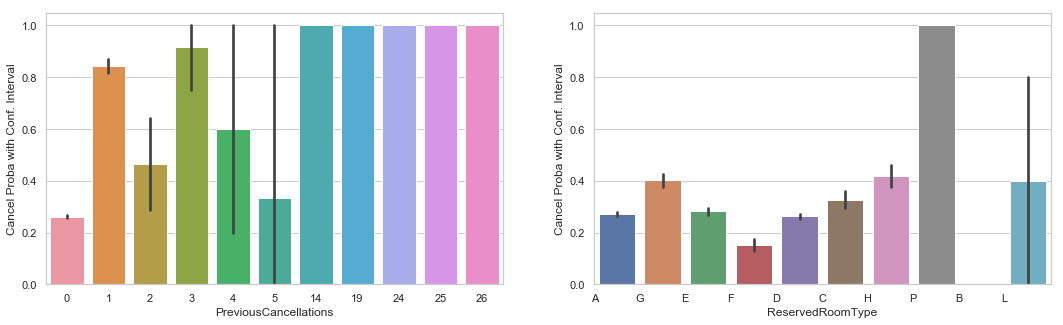

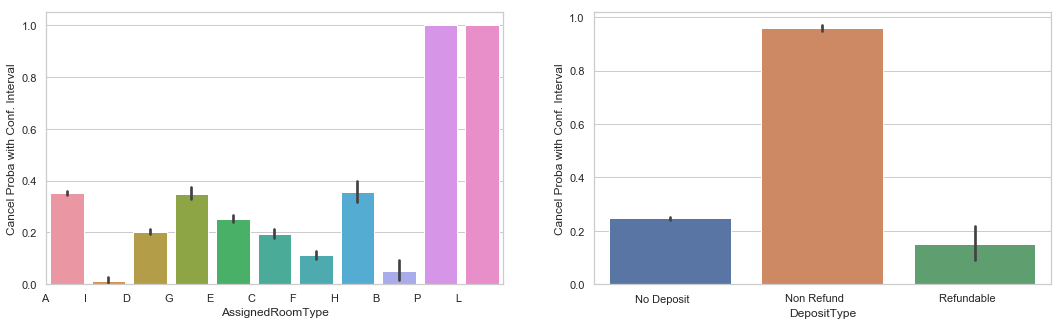

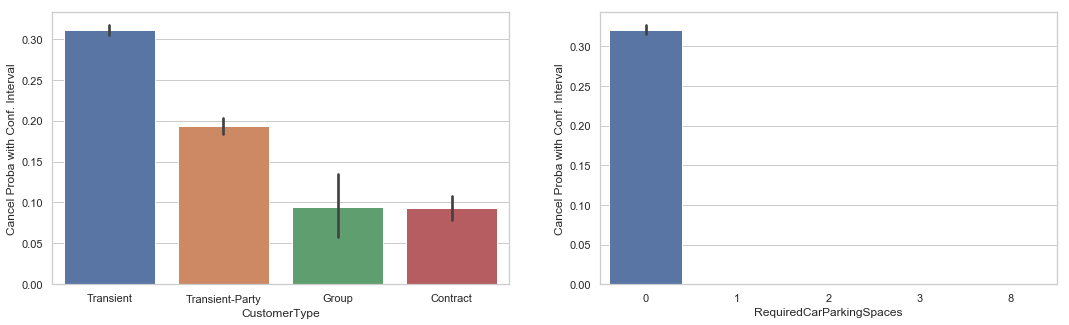

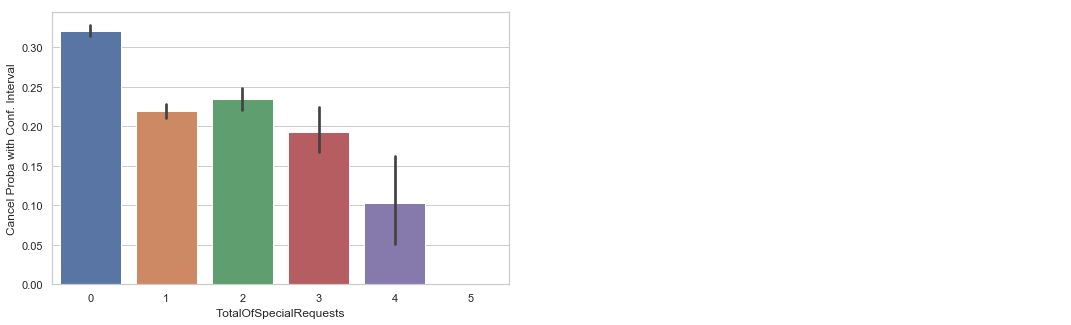

In [10]:
# Sort data by ArrivalDateMonth to make sure that months are ordered correctly on the x-axis.
data_sorted = data.copy()
months = ["January", "February", "March", "April", "May", "June", 
          "July", "August", "September", "October", "November", "December"]
data_sorted['ArrivalDateMonth'] = pd.Categorical(data_sorted['ArrivalDateMonth'], categories=months, ordered=True)
data_sorted = data_sorted.sort_values(by = 'ArrivalDateMonth')

# Categorical-like variables with less than 12 categories
plt_cat_cols = [col for col in data.columns if (len(set(data[col])) <= 12) and (col != "IsCanceled")]

# Plotting probability of cancellation vs categories, with confidence interval.
# The iterator makes sure that each row contains two figures, without having to treat odd/even cases manually.
iterator_ax = 0
for i, col in enumerate(plt_cat_cols):
    if i ==0:
        fig, current_ax = plt.subplots(figsize = (12,5))
    else:
        try:
            current_ax = next(iterator_ax)
        except:
            plt.show()
            fig, ax = plt.subplots(1, 2, figsize = (18, 5))
            iterator_ax = iter(ax)
            current_ax = next(iterator_ax)
    sns.barplot(x = col, y = 'IsCanceled', data = data_sorted, ax = current_ax)
    current_ax.set(ylabel = "Cancel Proba with Conf. Interval")
try:
    while True:
        current_ax = next(iterator_ax)
        current_ax.set_axis_off()
except:
    pass
plt.show()

We observe some normal patterns here:
* In summer months, the probability of cancellation is higher.
* Trasient customers are more likely to cancel than group customers or contract customers (variable "CustomerType").
* If the customer has more special requests, he is less likely to cancel.

The interesting thing here is the variable DepositType, where we see that customers who are asked to make a non-refundable deposit are in fact more likely to cancel. This may mean that the hotel does in fact a good job at identifying customers that are likely to cancel, but the deposit amount may not be high enough to prevent the cancellation from happening. In addition, more than 20% of "no deposit" customers still cancel their bookings, so machine learning may be useful to help the hotel reduce this number. 

Now let us look at non-categorical variables. We plot the probability of cancelation versus values of these variables, using logistic regression. Due to the cost of computation, confidence intervals are not plotted.

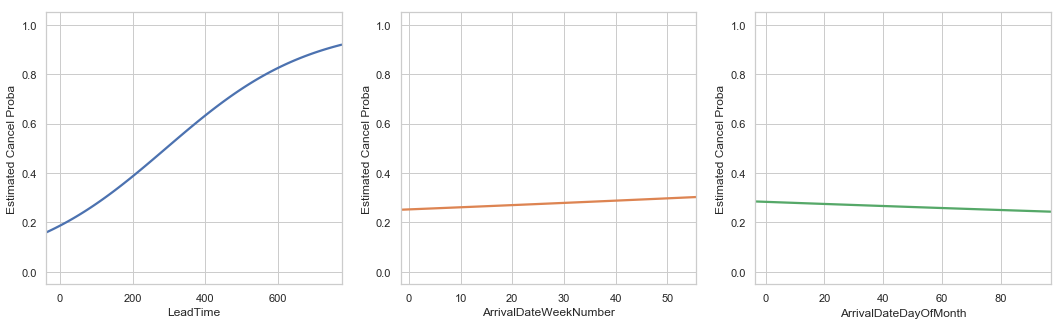

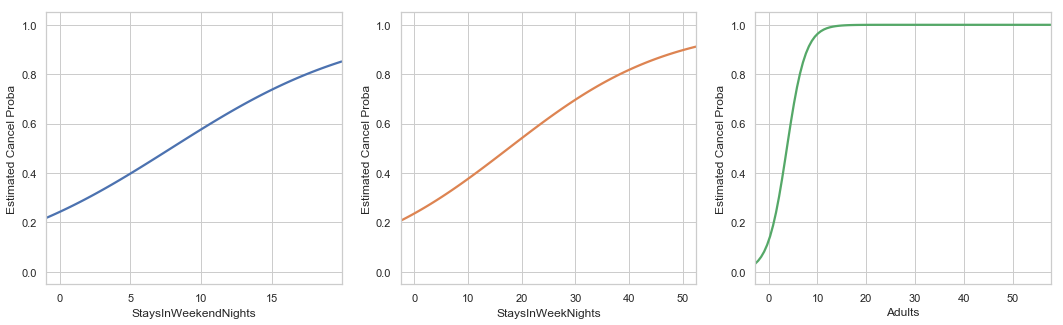

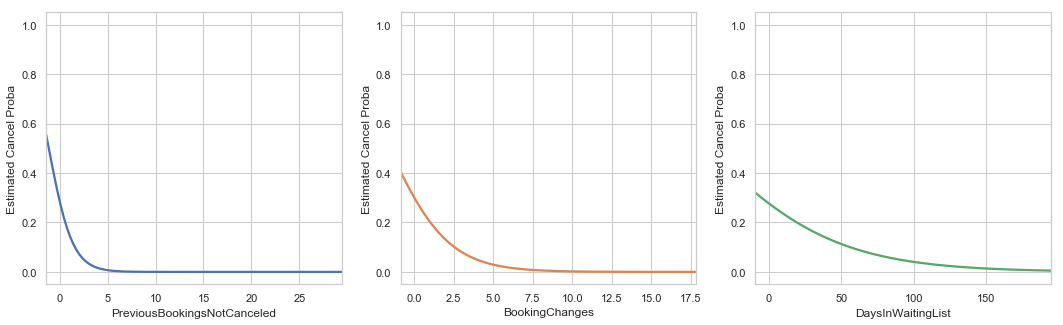

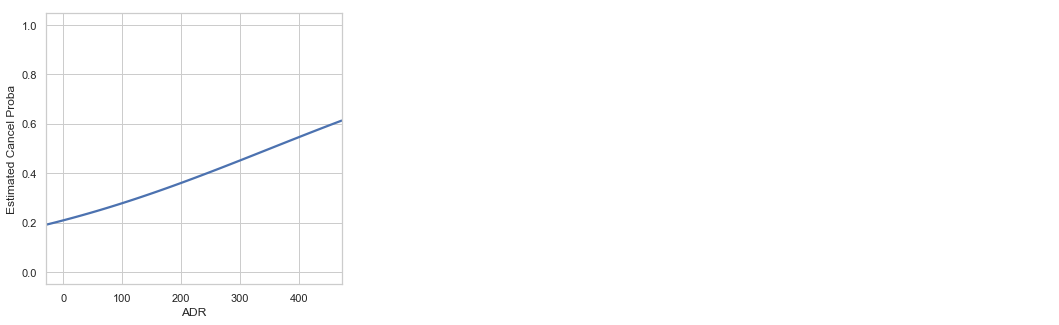

In [11]:
# non-categorical variables
plt_reg_cols = [col for col in data.columns if (len(set(data[col])) >= 12) and (str(data[col].dtype) != "object")]

# Plot cancellation probability versus values of each variable.
# The iterator makes sure that each line contains 3 plots, without having to treat mod = 0, mod = 1 and mod = 2 cases manually
iterator_ax = 0
for col in plt_reg_cols:
    try:
        current_ax = next(iterator_ax)
    except:
        plt.show()
        fig, ax = plt.subplots(1, 3, figsize = (18, 5))
        iterator_ax = iter(ax)
        current_ax = next(iterator_ax)
    sns.regplot(x = col, y = 'IsCanceled', data = data, scatter_kws = {'s':0}, ax = current_ax, logistic = True, ci = None)
    current_ax.set(ylabel = 'Estimated Cancel Proba')
try:
    while True:
        current_ax = next(iterator_ax)
        current_ax.set_axis_off()
except:
    pass
plt.show()

Again, let us summary some important patterns that we discovered:
* The longer the customer reserved a hotel before he arrives, the more he is likely to cancel (variable LeadTime)
* If a customer had previously made more than 5 bookings without cancellation, then almost surely he won't cancel his future bookings.
* The busier the hotel is, the higher the proportion of cancelled bookings will be (variable ADR - Average Daily Rate).

Now we will look at the importance of each feature using the Mutual Information criteria. Look at the help file for more information

In [12]:
from sklearn.feature_selection import mutual_info_classif
#help(mutual_info_classif)

The function mutual_info_classif can treat categorical variables, but they only take a numpy array. So we need to convert strings to numbers.

In [13]:
obj_cols = data.select_dtypes(['object']).columns

data_num = data.copy()
data_num[obj_cols] = data_num[obj_cols].apply(lambda t: t.astype('category'))
data_num[obj_cols] = data_num[obj_cols].apply(lambda t: t.cat.codes)

The delicate point is that mutual_info_classif distinguishes between discrete and continuous variables. In fact, discrete variables do not have to be categorical. For example, the number of bookings is a discrete variable (because it takes value in $\mathbb{Z}$ but it is not categorical variable by nature. Again, see the documentation of the function mutual_info_classif. The thing to note here is that in our case, only "ADR" is truly a continuous variable.

In [14]:
data_num_except_target = data_num.iloc[:,1:]
discrete_index = np.array(data_num_except_target.columns != 'ADR')

So we have been waiting long enough... Let us see the importance of each feature using the Mutual information criteria.

/Users/haidang/anaconda/lib/python3.6/site-packages/sklearn/feature_selection/mutual_info_.py:251: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if discrete_features == 'auto':


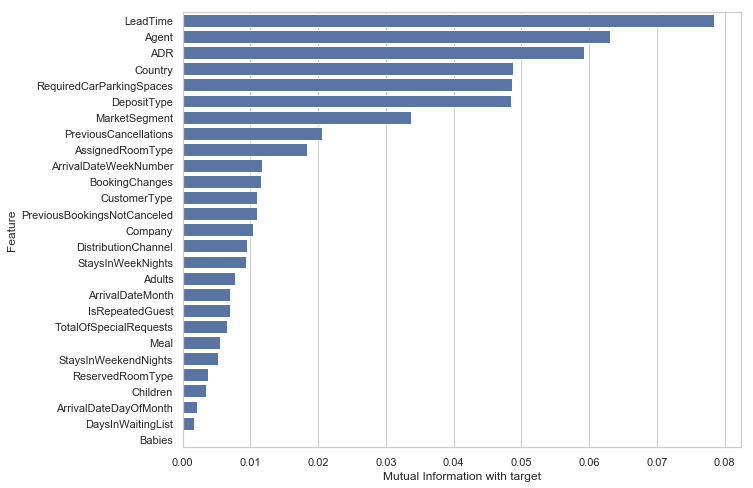

In [15]:
mi = mutual_info_classif(data_num_except_target.values, data_num['IsCanceled'].values, discrete_features=discrete_index)
mi = pd.DataFrame({'Feature': data_num_except_target.columns.values, 'Mutual Information with target': mi}).sort_values(by = 'Mutual Information with target', ascending = False)
sns.barplot(x = 'Mutual Information with target', y = 'Feature', data = mi, color = 'b', ax = plt.subplots(figsize = (10, 8))[1])

## Workflow <a name="ph3"></a>

The workflow is: first, we use a feature extractor to do preprocessing and feature engineering. Then we pass the processed data to a classifier.

<img src="./img/FE.png">

The usual way to treat categorical variables is to use one hot encoding, for example with pandas' get_dummies function. The difficulty here is that there are categorical variables with a high number of categories, and each subset of the train set (that is created for example by the cross validation procedure) may not contain all the categories of a categorical variables. Therefore, naive one hot encoding or dummy encoding may create train and test dataframes of different sizes.

In [16]:
data = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
print(len(set(data['Agent']))) # There are 178 different agents on train data...
print(len(set(test['Agent']))) # but only 139 different agents on test data

178
139


Why does this happen? Let us look at the occurence table of the variable "Agent" for the train data.

In [17]:
from collections import Counter
occurences = pd.DataFrame(Counter(data['Agent']), index=['Occurences']).T
occurences.sort_values(by = 'Occurences').head()

,Occurences
34,1
114,1
182,1
476,1
167,1


It is clear. There are some infrequent categories that occured only once in the train dataset (which contains about 30000 rows). If we split train into two parts for cross-validation, it is sure that these categories only occur in one part. Here we propose one possible solution which consists of grouping all infrequent values together:

In [18]:
def replace_infrequent_values(X, threshold, rvalue):
    """
    In an iterable X, replace values that occur with frequent less than a certain threshold with a user-definied rvalue.
    """
    X = X.copy()
    occ = Counter(X)
    N = len(X)
    for key in occ.keys():
        occ[key] /= N
    infrequent_values = [key for key in occ.keys() if occ[key] < threshold]
    for i, x in enumerate(X):
        if x in infrequent_values:
            X[i] = rvalue
    return X

Now we remove all categories of the variable "Agent" which occur in less than 5% of the data.

In [19]:
data['Agent'] = replace_infrequent_values(data['Agent'], 0.05, -1)
test['Agent'] = replace_infrequent_values(test['Agent'], 0.05, -1)
print(len(set(test['Agent'])))
print(len(set(data['Agent'])))

4
4


It seems to be working. It can be proved that with high probability, this procedure leads to a dataframe of consistent size. However, here, to make sure that the starting kit __always__ run, we do not use dummy encoding but rather keep the dataframe as it is (after marking categorical variables as such) and use a classifier that can deal with pandas dataframe directly.

In [20]:
%%file submissions/starting_kit/feature_extractor.py
import pandas as pd
class FeatureExtractor:
    def __init__(self):
        pass
    
    def fit(self, X_df, y):
        pass
    
    def transform(self, X_df):
        # Handle mising data
        X_df_2 = X_df.fillna(-1)
        
        # Transform categorical features into pandas's categorical type
        non_numeric_columns = ['ArrivalDateMonth', 'Meal', 'Country', 'MarketSegment', 'DistributionChannel', 
                               'ReservedRoomType', 'AssignedRoomType', 'DepositType', 'Agent', 'Company', 
                               'CustomerType']
        X_df_2[non_numeric_columns] = X_df_2[non_numeric_columns].astype('category')
        
        return X_df_2

Overwriting submissions/starting_kit/feature_extractor.py


In [21]:
%%file submissions/starting_kit/classifier.py
from sklearn.base import BaseEstimator
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import lightgbm as lgb
import numpy as np

class Classifier(BaseEstimator):
    def __init__(self):
        self.model = make_pipeline(StandardScaler(), LogisticRegression())
    
    def fit(self, X, y):
        
        # Train using traditional Gradient Boosting Decision Tree (of lightgbm package)
        # Train data set
        train_data = lgb.Dataset(X, label=y) 
        
        # Parameters
        param = {'boosting':'gbdt', 'num_leaves':31, 'objective':'binary',
            'learning_rate':.05, 'max_bin':255, 'min_data_in_leaf':100,
            'bagging_freq':1, 'bagging_fraction':1., 'lambda_l1':1, 'lambda_l2':1,
            'verbose':-1}
        param['metric'] = 'binary_logloss'
        
        num_round = 600
        
        # Train
        self.model = lgb.train(param, train_data, num_round)
        
    def predict_proba(self, X):
        pred = self.model.predict(X)
        return np.array([1 - pred, pred]).T

Overwriting submissions/starting_kit/classifier.py


## Submission <a name="ph4"></a>

It is important to test your submission locally before submitting them to [ramp.studio](http://www.ramp.studio). The data set we use at the backend is usually different from what you find in the starting kit, so the score may be different.

The usual way to work with RAMP is to explore solutions, add feature transformations, select models, perhaps do some AutoML/hyperopt, etc., locally, and checking them with ramp_test_submission.

In [22]:
import os
#os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE" # for MacOS compatibility

In [23]:
!ramp_test_submission --submission starting_kit

Testing Hotel booking cancellation prediction
Reading train and test files from ./data ...
Reading cv ...
Training ./submissions/starting_kit ...
CV fold 0
/Users/haidang/anaconda/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_9.4.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)
	score   mf1  prec   rec
	train  0.91  0.92  0.90
	valid  0.81  0.82  0.81
	test   0.82  0.85  0.81
CV fold 1
	score   mf1  prec   rec
	train